In [1]:
import numpy as np 
import pandas as pd
import re
import emoji
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from sklearn.preprocessing import LabelEncoder
import nltk
from pyvi import ViTokenizer

nltk.download('wordnet')
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, GRU, LayerNormalization, GlobalMaxPooling1D, Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from underthesea import word_tokenize


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HELLO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [78]:
data = pd.read_csv('Tiki_Smartphone.csv')

In [79]:
data.head()

,id_x,product_name,brand_id,brand_name,short_description,price,list_price,quantity_sold,discount,discount_rate,...,id_y,timeline,title,content,thank_count,product_id,product_attributes,rating,customer_id,customer_name
0,194037967,Điện thoại Samsung Galaxy Z Flip 4 (8GB/256GB)...,18802,Samsung,Nhỏ gọn trong lòng bàn tay của bạnSamsung Gala...,10990000,25990000,100,15000000,58,...,19467761,8/18/2023 15:16,Cực kì hài lòng,"Nhân viên giao hàng nhanh chóng, điện thoại nh...",3,194037967,['Màu: Xám'],5,13209823,Nguyễn Văn Đủ
1,194037967,Điện thoại Samsung Galaxy Z Flip 4 (8GB/256GB)...,18802,Samsung,Nhỏ gọn trong lòng bàn tay của bạnSamsung Gala...,10990000,25990000,100,15000000,58,...,19387346,7/17/2023 21:03,Cực kì hài lòng,"Chụp đẹp , nhỏ gọn , máy rất đẹp và giá tốt",2,194037967,['Màu: Xanh Dương'],5,1462072,Thanh Nhan Cao
2,194037967,Điện thoại Samsung Galaxy Z Flip 4 (8GB/256GB)...,18802,Samsung,Nhỏ gọn trong lòng bàn tay của bạnSamsung Gala...,10990000,25990000,100,15000000,58,...,18447872,12/18/2022 2:26,Cực kì hài lòng,Hàng chất lương,3,194037967,['Màu: Tím'],5,12085136,Quang Hưng
3,194037967,Điện thoại Samsung Galaxy Z Flip 4 (8GB/256GB)...,18802,Samsung,Nhỏ gọn trong lòng bàn tay của bạnSamsung Gala...,10990000,25990000,100,15000000,58,...,18486092,12/23/2022 12:18,Cực kì hài lòng,Máy rất tốt nhưng lúc mua tôi quên không mua k...,10,194037967,['Màu: Tím'],5,288387,nguyễn Mỹ Dung
4,194037967,Điện thoại Samsung Galaxy Z Flip 4 (8GB/256GB)...,18802,Samsung,Nhỏ gọn trong lòng bàn tay của bạnSamsung Gala...,10990000,25990000,100,15000000,58,...,18292422,11/26/2022 15:52,Cực kì hài lòng,"SP tốt, giao hàng nhanh, tuy nhiên shop chưa c...",1,194037967,['Màu: Vàng'],5,28513944,Thuỳ Dung


## Processing Data

In [80]:
sentences = data['content'].values
labels = data['title'].values
labels_dict = {'Rất không hài lòng': 1, 'Không hài lòng':2,'Bình thường':3, 'Hài lòng':4, 'Cực kì hài lòng': 5}

In [81]:
lookup_dict = {'sp':'sản phẩm', 'dt':'điện thoại', "ko" : "không", "seal" : "tem_mới", "gút chóp" : "tốt", "m" : "mình", "ok" : "tốt", "chẹp" : "đẹp",
               "đc" : "được", "chất" : "tốt","gudddddddddddddddddddd":"tốt", "vs" : "với", "ng" : "người", "triệu like":"quá tốt", "feedback":"phản hồi",
               "ngon lành cành đào":"quá tốt", "dag":"đang","qc":"quảng cáo"}
# Chuyển biểu tượng cảm xúc thành văn bản
def convert_emojis(text):
    if isinstance(text, str):
        return emoji.demojize(text, delimiters=("", ""))
    else:
        return text

def clean_text(text, lookup_dict):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = convert_emojis(text)
        # Xóa các dấu câu
        text = text.translate(str.maketrans('', '', string.punctuation))
        words = text.split()
        normalized_words = [lookup_dict.get(word, word) for word in words]
        normalized_text = ' '.join(normalized_words)
        # Sử dụng underthesea để tách từ tiếng Việt
        tokenized_text = word_tokenize(normalized_text, format="text")
        return tokenized_text
    else:
        return text




In [82]:
sentences = [convert_emojis(sentence) for sentence in sentences]

In [83]:
sentences = [clean_text(sentence, lookup_dict) for sentence in sentences]

In [84]:
sentences

['nhân_viên giao hàng nhanh_chóng điện_thoại nhỏ_nhắn cầm như hợp kem chống nắng vậyđiểm_trừ là sạc pin hơi lâupin tụt nhanh như tụt_quầnkhông thực_sự mượt_mà đâumáy mới màcó vẻ hơi lag nhẹnhà bán hàng uy_tín',
 'chụp đẹp nhỏ gọn máy rất đẹp và giá tốt',
 'hàng tốt lương',
 'máy rất tốt nhưng lúc mua tôi quên không mua kèm_gói bảo_vệ màn_hình vậy giờ tôi có_thể mua lại gói này riêng không',
 'sản_phẩm tốt giao hàng nhanh tuy_nhiên shop chưa có mục chat mình muốn hỏi kích_hoạt bảo_hành thế_nào shop',
 nan,
 'giao hàng siêu nhanh điện_thoại đẹp đã dán màn_hình hàng chính hãng nguyên_tem_mới',
 'máy mới nguyên tem_mới',
 nan,
 'điện_thoại của tôi chưa được kích_hoạt bảo_hành nhờ tiki xem giúp',
 nan,
 'z flip4 rất đẹp chỉ nhanh hết pin growingheart',
 'điện_thoại z flip 4 nguyên đai nguyên_kiện của samsung',
 nan,
 'mua cai điện_thoại không tặng nổi_cục xạc pin nữq',
 'giá khá tốt so với thị_trường',
 'máy rát đẹp được tiki giao rất yên_tâm',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [85]:

# Sử dụng hàm map với numpy.vectorize để ánh xạ labels
map_func = np.vectorize(lambda x: labels_dict.get(x, -1))  # Đánh dấu giá trị không tìm thấy với -1
labels = map_func(labels)


In [86]:
labels

array([5, 5, 5, ..., 5, 1, 5])

In [87]:
sentences = np.array(sentences)


In [88]:
labels.shape

(12164,)

In [89]:
sentences.shape

(12164,)

In [90]:
df = pd.DataFrame({
    'sentences': sentences,
    'labels': labels
})

In [91]:
df.head()

,sentences,labels
0,nhân_viên giao hàng nhanh_chóng điện_thoại nhỏ...,5
1,chụp đẹp nhỏ gọn máy rất đẹp và giá tốt,5
2,hàng tốt lương,5
3,máy rất tốt nhưng lúc mua tôi quên không mua k...,5
4,sản_phẩm tốt giao hàng nhanh tuy_nhiên shop ch...,5


In [92]:
df

,sentences,labels
0,nhân_viên giao hàng nhanh_chóng điện_thoại nhỏ...,5
1,chụp đẹp nhỏ gọn máy rất đẹp và giá tốt,5
2,hàng tốt lương,5
3,máy rất tốt nhưng lúc mua tôi quên không mua k...,5
4,sản_phẩm tốt giao hàng nhanh tuy_nhiên shop ch...,5
...,...,...
12159,nan,5
12160,nan,5
12161,nan,5
12162,bán điện_thoại bị hư mà cả 10 ngày không giải_...,1


In [93]:
# Loại bỏ dòng có giá trị labels là -1
df = df[df['labels'] != -1]


In [94]:
df = df[df['sentences'].astype(str) != 'nan']

In [95]:
df

,sentences,labels
0,nhân_viên giao hàng nhanh_chóng điện_thoại nhỏ...,5
1,chụp đẹp nhỏ gọn máy rất đẹp và giá tốt,5
2,hàng tốt lương,5
3,máy rất tốt nhưng lúc mua tôi quên không mua k...,5
4,sản_phẩm tốt giao hàng nhanh tuy_nhiên shop ch...,5
...,...,...
12140,tốt,5
12141,tốt lượng tốt,5
12142,tốt,5
12143,sản_phẩm tốt rất tốt,5


In [96]:
sentences = df['sentences'].values
labels = df['labels'].values

In [108]:
labels

array([5, 5, 5, ..., 5, 5, 1])

## Trực quan độ dài của từ để chọn padding và truncate hợp lý cho model 

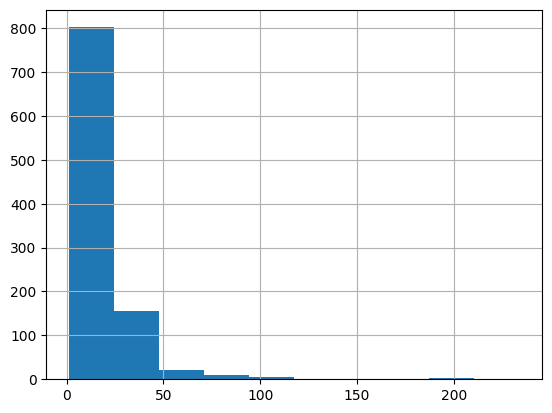

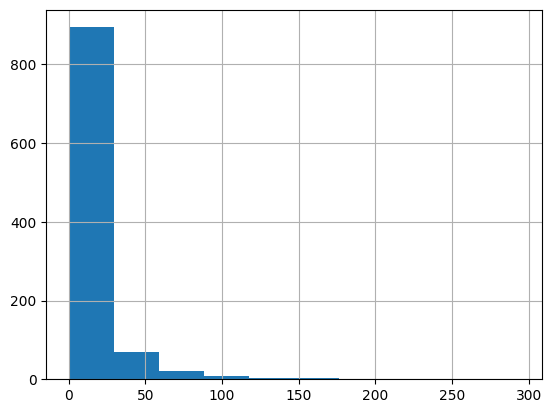

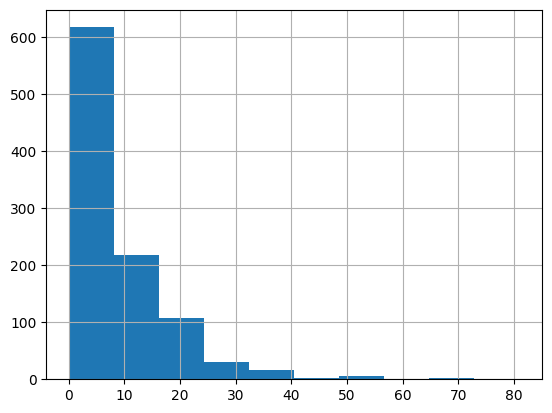

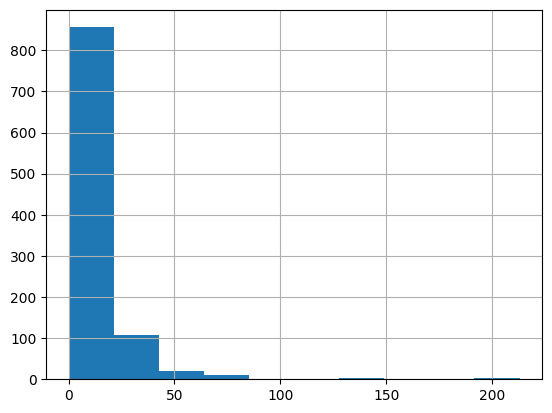

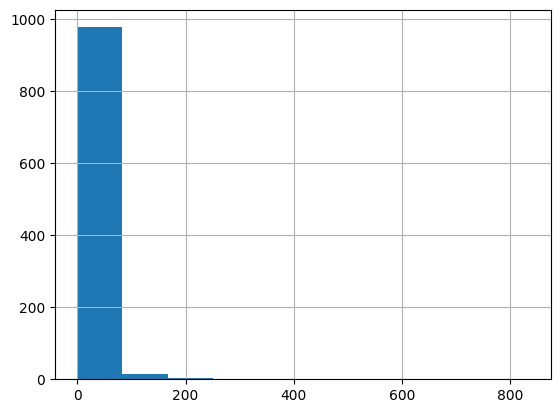

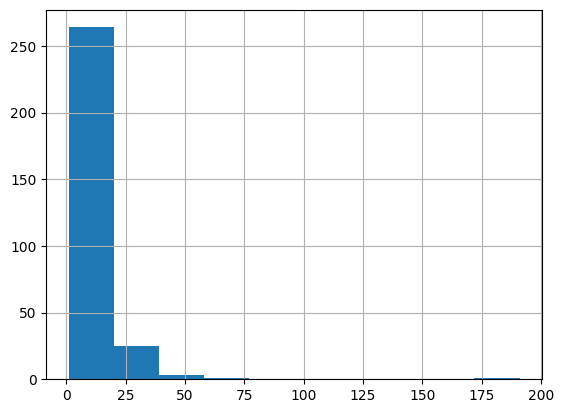

In [97]:
seq_len = [len(i.split()) for i in sentences[0:1000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

seq_len = [len(i.split()) for i in sentences[1000:2000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

seq_len = [len(i.split()) for i in sentences[2000:3000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

seq_len = [len(i.split()) for i in sentences[3000:4000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

seq_len = [len(i.split()) for i in sentences[4000:5000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

seq_len = [len(i.split()) for i in sentences[5000:5295]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

## Word2Vec để xử lý văn bản

In [102]:
vocab_size = 10000
embedding_dim = 64
max_length = 800

In [99]:
tokenizer = Tokenizer(num_words= vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)

In [100]:
tokenizer.word_index

{'<OOV>': 1,
 'hàng': 2,
 'tốt': 3,
 'giao': 4,
 'nhanh': 5,
 'không': 6,
 'máy': 7,
 'mới': 8,
 'giá': 9,
 'tiki': 10,
 'mua': 11,
 'rất': 12,
 'sản': 13,
 'phẩm': 14,
 'có': 15,
 'đẹp': 16,
 'được': 17,
 'mình': 18,
 'nguyên': 19,
 'chính': 20,
 'hãng': 21,
 'tem': 22,
 'dùng': 23,
 'và': 24,
 'là': 25,
 'điện': 26,
 'thì': 27,
 'nhưng': 28,
 'gói': 29,
 'nhận': 30,
 'thoại': 31,
 'đóng': 32,
 'nên': 33,
 'đúng': 34,
 'đã': 35,
 'chưa': 36,
 'ổn': 37,
 'lượng': 38,
 'hơn': 39,
 'mà': 40,
 'hình': 41,
 '1': 42,
 'với': 43,
 'ngày': 44,
 'quá': 45,
 'như': 46,
 'cho': 47,
 'của': 48,
 'bảo': 49,
 'cẩn': 50,
 'cũng': 51,
 'thận': 52,
 'thấy': 53,
 'trong': 54,
 'pin': 55,
 'màu': 56,
 'hành': 57,
 'shop': 58,
 'còn': 59,
 '2': 60,
 'bị': 61,
 'lại': 62,
 'khi': 63,
 'dụng': 64,
 'này': 65,
 'hơi': 66,
 'xài': 67,
 'lòng': 68,
 'khá': 69,
 'hài': 70,
 'để': 71,
 'đặt': 72,
 'sau': 73,
 'rồi': 74,
 'sao': 75,
 'gì': 76,
 'về': 77,
 'k': 78,
 'luôn': 79,
 'màn': 80,
 'lần': 81,
 'mượt': 82

In [101]:
sentences = tokenizer.texts_to_sequences(sentences)

In [103]:
sentences

[[196,
  201,
  4,
  2,
  5,
  235,
  26,
  31,
  280,
  398,
  236,
  46,
  99,
  810,
  285,
  811,
  812,
  381,
  25,
  88,
  55,
  66,
  813,
  403,
  5,
  46,
  403,
  814,
  350,
  253,
  82,
  40,
  815,
  8,
  816,
  419,
  66,
  343,
  817,
  184,
  2,
  259,
  202],
 [103, 16, 280, 344, 7, 12, 16, 24, 9, 3],
 [2, 3, 616],
 [7,
  12,
  3,
  28,
  119,
  11,
  122,
  530,
  6,
  11,
  239,
  29,
  49,
  581,
  80,
  41,
  215,
  145,
  122,
  15,
  224,
  11,
  62,
  29,
  65,
  547,
  6],
 [13,
  14,
  3,
  4,
  2,
  5,
  169,
  188,
  58,
  36,
  15,
  706,
  531,
  18,
  304,
  305,
  95,
  90,
  49,
  57,
  219,
  129,
  58],
 [4, 2, 120, 5, 26, 31, 16, 35, 269, 80, 41, 2, 20, 21, 19, 22, 8],
 [7, 8, 19, 22, 8],
 [26, 31, 48, 122, 36, 17, 95, 90, 49, 57, 443, 10, 189, 412],
 [556, 818, 12, 16, 92, 5, 136, 55, 819],
 [26, 31, 556, 820, 233, 19, 444, 19, 237, 48, 249],
 [11, 732, 26, 31, 6, 170, 582, 332, 668, 55, 821],
 [9, 69, 3, 114, 43, 315, 333],
 [7, 775, 16, 17, 10, 4

In [104]:
padded_senquences = pad_sequences(sentences, maxlen= max_length, truncating= 'post', padding= 'post')

In [105]:
pickle.dump(tokenizer, open( "tokenizer.pkl", "wb" )) #Lưu lại tokenizer để dùng sau

In [107]:
padded_senquences

array([[196, 201,   4, ...,   0,   0,   0],
       [103,  16, 280, ...,   0,   0,   0],
       [  2,   3, 616, ...,   0,   0,   0],
       ...,
       [  3,   0,   0, ...,   0,   0,   0],
       [ 13,  14,   3, ...,   0,   0,   0],
       [184,  26,  31, ...,   0,   0,   0]])

In [106]:
padded_senquences.shape

(5294, 800)

In [110]:
# Điều chỉnh các nhãn để bắt đầu từ 0 thay vì 1
labels_adjusted = labels - 1

# Chuyển đổi nhãn đã điều chỉnh sang dạng one-hot
label_tf = tf.keras.utils.to_categorical(labels_adjusted, num_classes=5, dtype='float32')

In [111]:
label_tf.shape

(5294, 5)

## Chia thành 3 tập dữ liệu là train, val và test

In [112]:
X_train, X_val, y_train, y_val = train_test_split(padded_senquences, label_tf, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
print("training sample: ", len(X_train))
print("validation sample: ", len(X_val))
print("test sample: ", len(X_test))

training sample:  3811
validation sample:  1059
test sample:  424


## Tiến Hành Segement bằng Model LSTM và CNN

In [124]:
def generate_model(data_vocab_size=10000, dropout_threshold=0.4, embedding_output_dim=32, input_length=800):
    initializer = GlorotNormal()

    # Define input layer
    input_layer = Input(shape=(input_length,))

    # Embedding layer
    feature = Embedding(input_dim=data_vocab_size, output_dim=embedding_output_dim, input_length=input_length, embeddings_initializer=initializer)(input_layer)

    # Convolutional layers
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(cnn_feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

    # LSTM and GRU layers
    lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer))(cnn_feature)
    lstm_feature = MaxPooling1D()(lstm_feature)

    gru_feature = Bidirectional(GRU(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer))(cnn_feature)
    gru_feature = MaxPooling1D()(gru_feature)
    gru_feature = LayerNormalization()(gru_feature)

    # Combining features
    combine_feature = tf.keras.layers.Concatenate()([lstm_feature, gru_feature])
    combine_feature = GlobalMaxPooling1D()(combine_feature)
    combine_feature = LayerNormalization()(combine_feature)

    # Classifier layers
    classifier = Dense(90, activation='relu')(combine_feature)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(70, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(50, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(30, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(5, activation='softmax')(classifier)

    # Create and compile the model
    model = Model(inputs=input_layer, outputs=classifier)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the model
model = generate_model()

# Print model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 800)]                0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 800, 32)              320000    ['input_7[0][0]']             
                                                                                                  
 conv1d_10 (Conv1D)          (None, 800, 32)              3104      ['embedding_6[0][0]']         
                                                                                                  
 max_pooling1d_20 (MaxPooli  (None, 400, 32)              0         ['conv1d_10[0][0]']           
 ng1D)                                                                                      

In [125]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_cnn_bilstm.h5', monitor='val_loss')
history = model.fit(x = X_train, y = y_train, validation_data = (X_val, y_val), epochs = 10, batch_size = 128, callbacks =[callback_model])

Epoch 1/10


30/30 [==============================] - 19s 372ms/step - loss: 1.1315 - accuracy: 0.6282 - val_loss: 0.7133 - val_accuracy: 0.8329
Epoch 2/10


C:\Users\HELLO\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 9s 308ms/step - loss: 0.7734 - accuracy: 0.8197 - val_loss: 0.6482 - val_accuracy: 0.8329
Epoch 3/10
30/30 [==============================] - 9s 306ms/step - loss: 0.6948 - accuracy: 0.8289 - val_loss: 0.6324 - val_accuracy: 0.8329
Epoch 4/10
30/30 [==============================] - 9s 317ms/step - loss: 0.6398 - accuracy: 0.8305 - val_loss: 0.5890 - val_accuracy: 0.8329
Epoch 5/10
30/30 [==============================] - 10s 321ms/step - loss: 0.5672 - accuracy: 0.8315 - val_loss: 0.5339 - val_accuracy: 0.8329
Epoch 6/10
30/30 [==============================] - 10s 320ms/step - loss: 0.5030 - accuracy: 0.8318 - val_loss: 0.5282 - val_accuracy: 0.8329
Epoch 7/10
30/30 [==============================] - 9s 308ms/step - loss: 0.4833 - accuracy: 0.8329 - val_loss: 0.5224 - val_accuracy: 0.8385
Epoch 8/10
30/30 [==============================] - 9s 311ms/step - loss: 0.4571 - accuracy: 0.8394 - val_loss: 0.5322 - val_accuracy: 0.8385
Epoch 9/10
30/3

In [126]:
model.load_weights("model_cnn_bilstm.h5")
model.evaluate(X_test,y_test)

14/14 [==============================] - 0s 24ms/step - loss: 0.6575 - accuracy: 0.8066


[0.6575383543968201, 0.8066037893295288]

In [2]:
def preprocess_raw_input(raw_input, tokenizer):
    # Giả định ViTokenizer hoặc một thư viện tương tự đã được sử dụng
    input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
    input_text_pre = " ".join(input_text_pre)
    input_text_pre_accent = word_tokenize(input_text_pre, format="text")
    print("Text preprocessed:", input_text_pre_accent)
    sentences = tokenizer.texts_to_sequences([input_text_pre_accent])
    padded_senquences = pad_sequences(sentences, maxlen= 800, truncating= 'post', padding= 'post')
    return padded_senquences 

def inference_model(input_feature, model):
    output = model(input_feature).numpy()[0]
    result = output.argmax()
    conf = float(output.max())
    labels_dict = {'Rất không hài lòng': 0, 'Không hài lòng':1,'Bình thường':2, 'Hài lòng':3, 'Cực kì hài lòng': 4}
    label = list(labels_dict.keys())
    return label[int(result)], conf

def prediction(raw_input, tokenizer, model):
    input_model = preprocess_raw_input(raw_input, tokenizer)
    result, conf = inference_model(input_model, model)
    return result, conf

# Load model và tokenizer
my_model = load_model('model_cnn_bilstm.h5')

with open("tokenizer.pkl", "rb") as input_file:
    my_tokenizer = pickle.load(input_file)

# Test the prediction
print(prediction("sữa chua ngon lắm", my_tokenizer, my_model))



Text preprocessed: sữa chua ngon lắm
('Cực kì hài lòng', 0.4069157838821411)


In [3]:
while(True):
    text = input()
    if text == "end":
        break
    else:
        print(prediction(text, my_tokenizer, my_model) [0]+"\n")

Text preprocessed: hàng cũng tốt
Cực kì hài lòng

Text preprocessed: hàng quá tệ
Rất không hài lòng

Text preprocessed: ok '
Cực kì hài lòng

Text preprocessed: hazzz shop bán quá chán
Rất không hài lòng

Text preprocessed: chịu shop luôn
Cực kì hài lòng

Text preprocessed: quá tệ
Rất không hài lòng

Text preprocessed: tệ quá
Rất không hài lòng

Text preprocessed: bán hàng không có tâm gì hết
Cực kì hài lòng

Text preprocessed: đth ship về thì hư_hỏng
Cực kì hài lòng

